## Python Week 8

November 23, 2019

If the installation was done properly on October 26, we are ready to start machine learning projects.
In the following weeks, we'll make a team and pick a project that you are interested in. In order to give you better ideas and understand what AI can do, we'll go over a few examples drawn from engineering and science. 

Today, let's continue our Keras programming with image denoising using autoencoder.
We'll use the dataset that we previously played with for our number recognition and plotting. So the data should be in your cloned repository.


In [5]:
import numpy as np

import tensorflow 

if tensorflow.__version__ < '2.0.0':
    import keras 
    from keras.models import Model
    from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
    print("using tensorflow ", tensorflow.__version__)
elif tensorflow.__version__ >= '2.0.0':
    from tensorflow import keras
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
    print("using tensorflow ", tensorflow.__version__)
## keras functions are well documented in the Keras Documentaion 
## https://keras.io

/home/jindogae/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


using tensorflow  1.9.0


Using TensorFlow backend.


In [6]:
Xtest3D = np.load('xtest.pickle', allow_pickle=True)
YtestAll = np.load('ytest.pickle', allow_pickle=True)

In [7]:
#Xtrain3D = np.load('xtrain.pickle', allow_pickle=True)
#Ytrain = np.load('ytrain.pickle', allow_pickle=True)

In [8]:
## original images have unsigned integer from 0 to 255 (8bit representation of gray scale color) 
## Since the convolutions are numerical computation, we change the data type to float32 and then 
## perform normalizations to [0,1] range

Xtest3D = Xtest3D.astype('float32')/255.
#Xtrain3D = Xtrain3D.astype('float32')/255.

In [9]:
## in order to conform to the shape of inputs to Conv2D
## Conv2D expects 4D array
## 1st index - sample index
## 2nd index - image x
## 3rd index - image y
## 4th index - channel (Ex. RGB values in color images)

Xtest4D = Xtest3D.reshape((*Xtest3D.shape, 1))
#Xtrain = Xtrain3D.reshape((*Xtrain3D.shape, 1))

In [10]:
## Since the computing power and time is limitted, let's reduce the size of training and test datasets 

Xtrain = Xtest4D[0:600,:]
Xtest = Xtest4D[1000:1100,:]

Ytrain = YtestAll[0:600]
Ytest  = YtestAll[1000:1100]

## Let's create noisy input data

XtrainNoisy = Xtrain + 0.5*np.random.randn(*Xtrain.shape)
XtestNoisy = Xtest + 0.5*np.random.randn(*Xtest.shape)

XtrainNoisy = np.clip(XtrainNoisy, 0., 1.)
XtestNoisy = np.clip(XtestNoisy, 0., 1.)



In [11]:
Ytrain.shape
Ytest.shape

(100,)

Text(0.5,1,'Noisy')

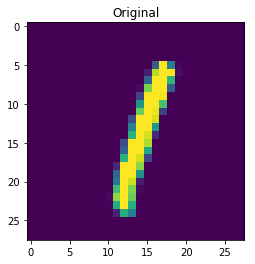

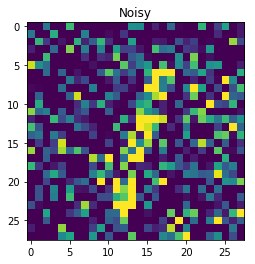

In [12]:
## Let's plot one of them

fig = plt.figure()
plt.imshow(Xtrain[5,:,:,0])
plt.title('Original')

fig = plt.figure()
plt.imshow(XtrainNoisy[5,:,:,0])
plt.title('Noisy')


In [13]:
## Let's check the shape and type of the our test dataset

print(Xtest.shape)
print(Xtest.dtype)


(100, 28, 28, 1)
float32


In [14]:
print(Xtrain.shape)
print(Xtrain.dtype)

(600, 28, 28, 1)
float32


In [15]:
## Let's define our neural network model that consists of Convolutional, Flattening, MaxPooling and UpSampling layers
## We can go deep into each layers and optimization if necessary and if our members are interested.

def model(choice = 2):
    '''
    input parameters
      choice - 1, classification of mnist handwriting images
               2, encoding and decoding for denoising
               
    output
      keras model defining the network from an input to the final output
    '''
    
    
    input_img = Input(shape=(28, 28, 1))
    x1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x2 = MaxPooling2D((2,2), padding='same')(x1)
    x3 = Conv2D(32, (3,3), activation='relu', padding='same')(x2)
    
    encoded = MaxPooling2D((2,2), padding='same')(x3)
    c1 = Flatten()(encoded)
    c2 = Dense(128, activation='relu')(c1)
    c3 = Dropout(0.2)(c2)
    
    ## this is the final output for classification
    classifierOutput = Dense(10, activation='softmax')(c3)
    
    ## The following layers from y4 to decoded is for denoising
    ## we'll cover this in the next meeting
    y4 = Conv2D(32, (3,3), activation='relu', padding='same')(encoded)
    y3 = UpSampling2D((2,2))(y4)
    y2 = Conv2D(32, (3,3), activation='relu', padding='same')(y3)
    y1 = UpSampling2D((2,2))(y2)
    
    decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(y1)
    
    if choice == 1:
        return Model(input_img, classifierOutput)
    elif choice == 2: 
        ## This part is for the next meeting
        return Model(input_img, decoded)    
    else:
        return Model(inputs=[input_img], outputs=[classifierOutput, decoded])
    

In [16]:
## Here we call a function and get our model defintion.
mydenoiser = model(2)  ## model(1) -classification, model(2) - denoising, model (0) - both
mydenoiser.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [17]:
## Once a model is defined, we need to configure the model for trainging 
## by selecting optimizer and loss function

mydenoiser.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
## This is the traing stage that is compute intensive and may require high performance computers
## or GPU machines if the size of the training dataset is huge
## 
## In the begining of notebook, we decimated the size of the training dataset to finish our meeting on time
## If you increase the epochs, the number of data repetition,
## the running time will increase linearly proportional to the epochs.
mydenoiser.fit(XtrainNoisy, Xtrain, epochs=100, batch_size=128)

Epoch 1/100
600/600 [==============================] - 1s 927us/step - loss: 0.1094 - acc: 0.8226
Epoch 2/100
600/600 [==============================] - 1s 1ms/step - loss: 0.1094 - acc: 0.8227
Epoch 3/100
600/600 [==============================] - 1s 920us/step - loss: 0.1097 - acc: 0.8227
Epoch 4/100
600/600 [==============================] - 1s 940us/step - loss: 0.1092 - acc: 0.8227
Epoch 5/100
600/600 [==============================] - 1s 966us/step - loss: 0.1098 - acc: 0.8229
Epoch 6/100
600/600 [==============================] - 1s 934us/step - loss: 0.1097 - acc: 0.8224
Epoch 7/100
600/600 [==============================] - 1s 950us/step - loss: 0.1090 - acc: 0.8230
Epoch 8/100
600/600 [==============================] - 1s 897us/step - loss: 0.1093 - acc: 0.8225
Epoch 9/100
600/600 [==============================] - 1s 931us/step - loss: 0.1090 - acc: 0.8227
Epoch 10/100
600/600 [==============================] - 1s 922us/step - loss: 0.1084 - acc: 0.8230
Epoch 11/100
600/600 

600/600 [==============================] - 1s 892us/step - loss: 0.1012 - acc: 0.8240
Epoch 84/100
600/600 [==============================] - 1s 851us/step - loss: 0.1009 - acc: 0.8237
Epoch 85/100
600/600 [==============================] - 1s 858us/step - loss: 0.1005 - acc: 0.8240
Epoch 86/100
600/600 [==============================] - 1s 853us/step - loss: 0.0999 - acc: 0.8240
Epoch 87/100
600/600 [==============================] - 1s 874us/step - loss: 0.0998 - acc: 0.8241
Epoch 88/100
600/600 [==============================] - 1s 843us/step - loss: 0.0997 - acc: 0.8241
Epoch 89/100
600/600 [==============================] - 1s 867us/step - loss: 0.0998 - acc: 0.8241
Epoch 90/100
600/600 [==============================] - 1s 857us/step - loss: 0.0997 - acc: 0.8240
Epoch 91/100
600/600 [==============================] - 1s 881us/step - loss: 0.0994 - acc: 0.8241
Epoch 92/100
600/600 [==============================] - 1s 851us/step - loss: 0.0993 - acc: 0.8241
Epoch 93/100
600/600 [=

In [19]:
Xpred = mydenoiser.predict(XtestNoisy)

In [20]:
mydenoiser.evaluate(XtestNoisy, Xtest)

100/100 [==============================] - 0s 1ms/step


[0.10933910965919495, 0.8267601943016052]

In [21]:
Xtest.shape

(100, 28, 28, 1)

In [22]:
XtestNoisy.shape

(100, 28, 28, 1)

In [23]:
def showNumbers(Xdata):
    numpic = 10
    plt.figure(figsize=(12,4))
    for i in range(numpic):
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(Xdata[i, :, :, 0])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


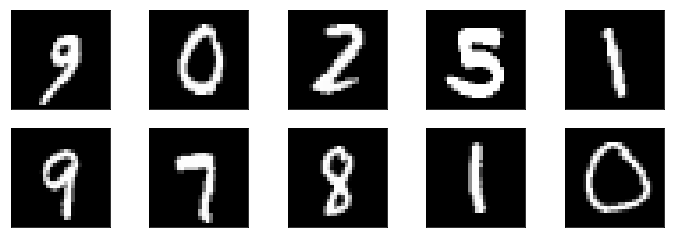

In [24]:
showNumbers(Xtest)

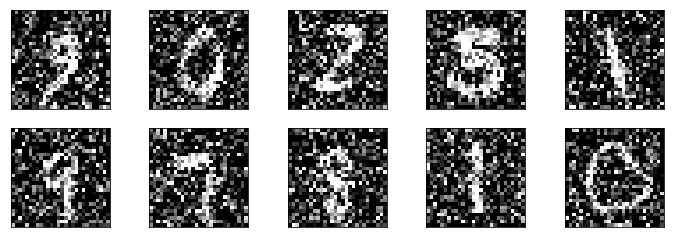

In [25]:
showNumbers(XtestNoisy)

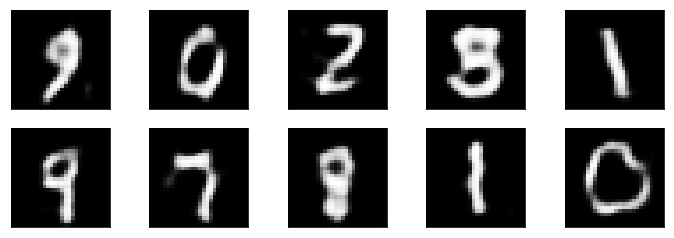

In [27]:
showNumbers(Xpred)